In [140]:
#Reference: https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac
import gensim.models.word2vec as Word2Vec
#import spacy


# Polysemy: the problem with word2vec


* When humans write dictionaries and thesauruses, we define concepts in relation to other concepts. 
* For automatic natural language processing, it's often more effective to use dictionaries that define concepts in terms of their usage statistics. 
* The word2vec family of models are the most popular way of creating these dictionaries. 
* Given a large sample of text, word2vec gives you a dictionary where each definition is just a row of, say, 300 floating-point numbers. 
* To find out whether two entries in the dictionary are similar, you ask how similar their definitions are — a well-defined mathematical operation.
* he problem with word2vec is the word part. 
* Consider a word like duck. No individual usage of the word duck refers to the concept "a waterfowl, or the action of crouching". 
* But that's the concept that word2vec is trying to model — because it smooshes all senses of the words together. 
* Nalisnick and Ravi (2015) noticed this problem, and suggested that we should allow word vectors to grow arbitrarily, so that we can do a better job of modelling complicated concepts. 
* This seems like a nice approach for subtle sense distinctions, but for cases like duck it's not so satisfying. What we want to do is have different vectors for the different senses. 
* They also want a simple way of knowing which meaning a given usage refers to. 
* For this, they need to analyse tokens in context. 
* This is where spaCy comes in.

# Sense2vec: Using NLP annotations for more precise vectors

* The idea behind sense2vec is super simple. 
* If the problem is that duck as in waterfowl and duck as in crouch are different concepts, the straight-forward solution is to just have two entries, duckN and duckV. 
* They've wanted to try this for some time. 
* So when Trask et al (2015) published a nice set of experiments showing that the idea worked well, they were easy to convince.
* They follow Trask et al in adding part-of-speech tags and named entity labels to the tokens. 
* Additionally, they merge named entities and base noun phrases into single tokens, so that they receive a single vector. 
* They're very pleased with the results from this, even though we consider the current version an early draft. * There's a lot more that can be done with the idea. 
* Multi-word verbs such as get up and give back and even take a walk or make a decision would be great extensions. 
* They also don't do anything currently to trim back phrases that are compositional — phrases which really are two words.

In [141]:
import numpy as np
import tensorflow as tf

corpus_raw = 'He is the king . The king is royal . She is the royal  queen '

# convert to lower case
corpus_raw = corpus_raw.lower()
print(corpus_raw)

he is the king . the king is royal . she is the royal  queen 


In [142]:
words = []

for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)

words = set(words) # so that all duplicate words are removed

word2int = {}
int2word = {}

vocab_size = len(words) # gives the total number of unique words

for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

In [143]:
print(word2int['king'])

6


In [144]:
print(int2word[4])

she


In [145]:
print(word2int[word])

6


In [146]:
raw_sentences = corpus_raw.split('.')

sentences = []

for sentence in raw_sentences:
    sentences.append(sentence.split())

In [147]:
sentence = np.array(sentences)
print(sentences)

[['he', 'is', 'the', 'king'], ['the', 'king', 'is', 'royal'], ['she', 'is', 'the', 'royal', 'queen']]


In [148]:
data = []

WINDOW_SIZE = 2

for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) :\
                                min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                data.append([word, nb_word])
print(data)

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]


In [149]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

x_train = [] # input word
y_train = [] # output word

for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))

# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
print(x_train)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [150]:
print(x_train.shape, y_train.shape)

(34, 7) (34, 7)


In [151]:
# making placeholders for x_train and y_train

x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))


In [152]:
EMBEDDING_DIM = 5 # you can choose your own number

W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))

b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM])) #bias

hidden_representation = tf.add(tf.matmul(x,W1), b1)

In [153]:
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))

b2 = tf.Variable(tf.random_normal([vocab_size]))

prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

In [154]:
sess = tf.Session()

init = tf.global_variables_initializer()

sess.run(init) #make sure you do this!

# define the loss function:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

# define the training step:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

n_iters = 10000

# train for n_iter iterations

for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})

    print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

loss is :  6.2130547
loss is :  5.184339
loss is :  4.5690346
loss is :  4.169736
loss is :  3.8825932
loss is :  3.668654
loss is :  3.5062506
loss is :  3.376632
loss is :  3.2666378
loss is :  3.1691806
loss is :  3.0807405
loss is :  2.9994507
loss is :  2.924194
loss is :  2.8542144
loss is :  2.788949
loss is :  2.7279482
loss is :  2.670837
loss is :  2.6172922
loss is :  2.5670292
loss is :  2.5197942
loss is :  2.4753578
loss is :  2.4335132
loss is :  2.3940709
loss is :  2.3568575
loss is :  2.3217158
loss is :  2.2884998
loss is :  2.2570758
loss is :  2.2273223
loss is :  2.1991267
loss is :  2.1723862
loss is :  2.1470063
loss is :  2.1229012
loss is :  2.0999918
loss is :  2.0782058
loss is :  2.057478
loss is :  2.0377476
loss is :  2.0189593
loss is :  2.0010624
loss is :  1.9840103
loss is :  1.9677604
loss is :  1.9522712
loss is :  1.9375058
loss is :  1.9234289
loss is :  1.9100064
loss is :  1.8972064
loss is :  1.8849983
loss is :  1.8733529
loss is :  1.8622409


loss is :  1.3812407
loss is :  1.3810076
loss is :  1.3807756
loss is :  1.3805442
loss is :  1.380314
loss is :  1.3800844
loss is :  1.3798561
loss is :  1.3796283
loss is :  1.3794018
loss is :  1.379176
loss is :  1.378951
loss is :  1.378727
loss is :  1.3785037
loss is :  1.3782814
loss is :  1.37806
loss is :  1.3778393
loss is :  1.3776197
loss is :  1.3774009
loss is :  1.377183
loss is :  1.3769659
loss is :  1.3767496
loss is :  1.3765342
loss is :  1.3763196
loss is :  1.376106
loss is :  1.3758932
loss is :  1.3756812
loss is :  1.37547
loss is :  1.3752596
loss is :  1.3750503
loss is :  1.3748416
loss is :  1.3746338
loss is :  1.3744267
loss is :  1.3742206
loss is :  1.3740152
loss is :  1.3738106
loss is :  1.3736067
loss is :  1.3734041
loss is :  1.373202
loss is :  1.3730006
loss is :  1.3728002
loss is :  1.3726006
loss is :  1.3724016
loss is :  1.3722035
loss is :  1.3720063
loss is :  1.37181
loss is :  1.3716141
loss is :  1.3714192
loss is :  1.3712249
loss 

loss is :  1.33278
loss is :  1.3327547
loss is :  1.3327293
loss is :  1.332704
loss is :  1.3326788
loss is :  1.3326538
loss is :  1.3326287
loss is :  1.3326039
loss is :  1.3325791
loss is :  1.3325543
loss is :  1.3325297
loss is :  1.3325051
loss is :  1.3324807
loss is :  1.3324562
loss is :  1.332432
loss is :  1.3324078
loss is :  1.3323836
loss is :  1.3323597
loss is :  1.3323357
loss is :  1.3323119
loss is :  1.3322881
loss is :  1.3322642
loss is :  1.3322407
loss is :  1.3322172
loss is :  1.3321937
loss is :  1.3321705
loss is :  1.332147
loss is :  1.3321239
loss is :  1.3321009
loss is :  1.3320777
loss is :  1.3320549
loss is :  1.332032
loss is :  1.3320091
loss is :  1.3319864
loss is :  1.3319637
loss is :  1.331941
loss is :  1.3319187
loss is :  1.3318963
loss is :  1.3318739
loss is :  1.3318516
loss is :  1.3318294
loss is :  1.3318073
loss is :  1.3317853
loss is :  1.3317634
loss is :  1.3317413
loss is :  1.3317196
loss is :  1.331698
loss is :  1.3316762


loss is :  1.3260566
loss is :  1.3260505
loss is :  1.3260443
loss is :  1.3260381
loss is :  1.3260319
loss is :  1.3260258
loss is :  1.3260196
loss is :  1.3260133
loss is :  1.3260072
loss is :  1.3260012
loss is :  1.3259951
loss is :  1.325989
loss is :  1.3259829
loss is :  1.3259768
loss is :  1.3259708
loss is :  1.3259648
loss is :  1.3259588
loss is :  1.3259528
loss is :  1.3259467
loss is :  1.3259407
loss is :  1.3259348
loss is :  1.3259288
loss is :  1.325923
loss is :  1.325917
loss is :  1.3259109
loss is :  1.3259052
loss is :  1.3258991
loss is :  1.3258933
loss is :  1.3258873
loss is :  1.3258815
loss is :  1.3258756
loss is :  1.3258699
loss is :  1.325864
loss is :  1.3258582
loss is :  1.3258524
loss is :  1.3258466
loss is :  1.3258408
loss is :  1.325835
loss is :  1.3258291
loss is :  1.3258234
loss is :  1.3258178
loss is :  1.325812
loss is :  1.3258064
loss is :  1.3258007
loss is :  1.3257948
loss is :  1.3257892
loss is :  1.3257835
loss is :  1.325777

loss is :  1.3239636
loss is :  1.3239609
loss is :  1.3239584
loss is :  1.3239555
loss is :  1.3239529
loss is :  1.3239505
loss is :  1.3239475
loss is :  1.323945
loss is :  1.3239424
loss is :  1.3239397
loss is :  1.3239372
loss is :  1.3239346
loss is :  1.3239319
loss is :  1.3239293
loss is :  1.3239266
loss is :  1.3239241
loss is :  1.3239214
loss is :  1.3239188
loss is :  1.3239163
loss is :  1.3239137
loss is :  1.3239111
loss is :  1.3239086
loss is :  1.323906
loss is :  1.3239033
loss is :  1.3239008
loss is :  1.3238982
loss is :  1.3238956
loss is :  1.323893
loss is :  1.3238903
loss is :  1.3238878
loss is :  1.3238853
loss is :  1.3238827
loss is :  1.3238802
loss is :  1.3238777
loss is :  1.3238751
loss is :  1.3238727
loss is :  1.3238701
loss is :  1.3238676
loss is :  1.3238649
loss is :  1.3238624
loss is :  1.3238599
loss is :  1.3238573
loss is :  1.323855
loss is :  1.3238524
loss is :  1.3238497
loss is :  1.3238475
loss is :  1.3238449
loss is :  1.3238

loss is :  1.3229325
loss is :  1.3229312
loss is :  1.3229297
loss is :  1.3229283
loss is :  1.3229269
loss is :  1.3229256
loss is :  1.3229239
loss is :  1.3229227
loss is :  1.3229212
loss is :  1.3229198
loss is :  1.3229185
loss is :  1.3229171
loss is :  1.3229156
loss is :  1.3229141
loss is :  1.3229128
loss is :  1.3229115
loss is :  1.32291
loss is :  1.3229086
loss is :  1.3229072
loss is :  1.3229058
loss is :  1.3229045
loss is :  1.322903
loss is :  1.3229017
loss is :  1.3229003
loss is :  1.3228989
loss is :  1.3228976
loss is :  1.3228961
loss is :  1.3228947
loss is :  1.3228935
loss is :  1.3228921
loss is :  1.3228906
loss is :  1.3228892
loss is :  1.322888
loss is :  1.3228866
loss is :  1.3228852
loss is :  1.3228838
loss is :  1.3228825
loss is :  1.322881
loss is :  1.3228797
loss is :  1.3228782
loss is :  1.3228769
loss is :  1.3228756
loss is :  1.3228743
loss is :  1.3228729
loss is :  1.3228716
loss is :  1.3228703
loss is :  1.322869
loss is :  1.322867

loss is :  1.3223573
loss is :  1.3223563
loss is :  1.3223555
loss is :  1.3223544
loss is :  1.3223537
loss is :  1.3223528
loss is :  1.3223519
loss is :  1.322351
loss is :  1.3223501
loss is :  1.3223494
loss is :  1.3223485
loss is :  1.3223475
loss is :  1.3223467
loss is :  1.322346
loss is :  1.3223449
loss is :  1.3223442
loss is :  1.3223432
loss is :  1.3223424
loss is :  1.3223414
loss is :  1.3223407
loss is :  1.3223399
loss is :  1.3223389
loss is :  1.322338
loss is :  1.3223373
loss is :  1.3223364
loss is :  1.3223354
loss is :  1.3223345
loss is :  1.3223338
loss is :  1.3223329
loss is :  1.3223319
loss is :  1.3223313
loss is :  1.3223304
loss is :  1.3223295
loss is :  1.3223287
loss is :  1.3223277
loss is :  1.3223269
loss is :  1.322326
loss is :  1.3223252
loss is :  1.3223243
loss is :  1.3223236
loss is :  1.3223226
loss is :  1.3223218
loss is :  1.3223209
loss is :  1.32232
loss is :  1.3223191
loss is :  1.3223184
loss is :  1.3223176
loss is :  1.322316

loss is :  1.3219714
loss is :  1.3219709
loss is :  1.3219702
loss is :  1.3219696
loss is :  1.321969
loss is :  1.3219684
loss is :  1.321968
loss is :  1.3219671
loss is :  1.3219668
loss is :  1.3219662
loss is :  1.3219656
loss is :  1.3219651
loss is :  1.3219644
loss is :  1.3219638
loss is :  1.3219633
loss is :  1.3219627
loss is :  1.321962
loss is :  1.3219614
loss is :  1.3219609
loss is :  1.3219603
loss is :  1.3219596
loss is :  1.3219594
loss is :  1.3219587
loss is :  1.3219581
loss is :  1.3219575
loss is :  1.321957
loss is :  1.3219564
loss is :  1.3219557
loss is :  1.3219551
loss is :  1.3219546
loss is :  1.3219539
loss is :  1.3219535
loss is :  1.3219529
loss is :  1.3219522
loss is :  1.3219519
loss is :  1.3219512
loss is :  1.3219507
loss is :  1.32195
loss is :  1.3219495
loss is :  1.3219489
loss is :  1.3219483
loss is :  1.3219479
loss is :  1.3219472
loss is :  1.3219466
loss is :  1.3219461
loss is :  1.3219455
loss is :  1.3219451
loss is :  1.321944

loss is :  1.3217154
loss is :  1.321715
loss is :  1.3217146
loss is :  1.321714
loss is :  1.3217136
loss is :  1.3217133
loss is :  1.3217129
loss is :  1.3217126
loss is :  1.321712
loss is :  1.3217115
loss is :  1.3217112
loss is :  1.3217108
loss is :  1.3217102
loss is :  1.3217099
loss is :  1.3217096
loss is :  1.3217093
loss is :  1.3217087
loss is :  1.3217082
loss is :  1.3217077
loss is :  1.3217076
loss is :  1.3217071
loss is :  1.3217067
loss is :  1.3217062
loss is :  1.3217058
loss is :  1.3217055
loss is :  1.321705
loss is :  1.3217045
loss is :  1.3217041
loss is :  1.3217038
loss is :  1.3217032
loss is :  1.321703
loss is :  1.3217026
loss is :  1.321702
loss is :  1.3217018
loss is :  1.3217013
loss is :  1.3217008
loss is :  1.3217005
loss is :  1.3217
loss is :  1.3216996
loss is :  1.3216994
loss is :  1.3216989
loss is :  1.3216983
loss is :  1.321698
loss is :  1.3216976
loss is :  1.3216971
loss is :  1.3216968
loss is :  1.3216963
loss is :  1.321696
los

loss is :  1.3215257
loss is :  1.3215253
loss is :  1.3215251
loss is :  1.3215246
loss is :  1.3215245
loss is :  1.3215243
loss is :  1.3215238
loss is :  1.3215235
loss is :  1.3215233
loss is :  1.3215227
loss is :  1.3215226
loss is :  1.3215224
loss is :  1.321522
loss is :  1.3215216
loss is :  1.3215214
loss is :  1.321521
loss is :  1.3215208
loss is :  1.3215203
loss is :  1.3215201
loss is :  1.3215197
loss is :  1.3215195
loss is :  1.3215191
loss is :  1.3215189
loss is :  1.3215185
loss is :  1.3215183
loss is :  1.3215178
loss is :  1.3215176
loss is :  1.3215172
loss is :  1.321517
loss is :  1.3215168
loss is :  1.3215165
loss is :  1.3215162
loss is :  1.3215158
loss is :  1.3215154
loss is :  1.3215151
loss is :  1.3215148
loss is :  1.3215146
loss is :  1.3215141
loss is :  1.3215139
loss is :  1.3215137
loss is :  1.3215134
loss is :  1.321513
loss is :  1.3215127
loss is :  1.3215123
loss is :  1.321512
loss is :  1.3215117
loss is :  1.3215115
loss is :  1.32151

loss is :  1.3213835
loss is :  1.3213834
loss is :  1.321383
loss is :  1.3213828
loss is :  1.3213825
loss is :  1.3213823
loss is :  1.3213819
loss is :  1.3213817
loss is :  1.3213816
loss is :  1.3213813
loss is :  1.3213811
loss is :  1.3213809
loss is :  1.3213806
loss is :  1.3213804
loss is :  1.3213801
loss is :  1.3213798
loss is :  1.3213797
loss is :  1.3213794
loss is :  1.3213791
loss is :  1.3213788
loss is :  1.3213786
loss is :  1.3213785
loss is :  1.3213782
loss is :  1.321378
loss is :  1.3213778
loss is :  1.3213775
loss is :  1.3213773
loss is :  1.3213769
loss is :  1.3213767
loss is :  1.3213766
loss is :  1.3213762
loss is :  1.321376
loss is :  1.3213757
loss is :  1.3213756
loss is :  1.3213754
loss is :  1.3213751
loss is :  1.3213748
loss is :  1.3213745
loss is :  1.3213743
loss is :  1.321374
loss is :  1.3213738
loss is :  1.3213736
loss is :  1.3213733
loss is :  1.3213731
loss is :  1.321373
loss is :  1.3213726
loss is :  1.3213723
loss is :  1.32137

loss is :  1.3212701
loss is :  1.3212699
loss is :  1.3212698
loss is :  1.3212694
loss is :  1.3212693
loss is :  1.3212692
loss is :  1.3212689
loss is :  1.3212687
loss is :  1.3212686
loss is :  1.3212683
loss is :  1.3212682
loss is :  1.321268
loss is :  1.3212677
loss is :  1.3212676
loss is :  1.3212674
loss is :  1.3212672
loss is :  1.3212671
loss is :  1.3212669
loss is :  1.3212667
loss is :  1.3212663
loss is :  1.3212662
loss is :  1.321266
loss is :  1.3212658
loss is :  1.3212655
loss is :  1.3212655
loss is :  1.3212652
loss is :  1.3212652
loss is :  1.321265
loss is :  1.3212649
loss is :  1.3212646
loss is :  1.3212644
loss is :  1.3212641
loss is :  1.3212639
loss is :  1.3212637
loss is :  1.3212634
loss is :  1.3212633
loss is :  1.3212632
loss is :  1.3212631
loss is :  1.3212628
loss is :  1.3212626
loss is :  1.3212626
loss is :  1.3212624
loss is :  1.321262
loss is :  1.3212618
loss is :  1.3212615
loss is :  1.3212615
loss is :  1.3212614
loss is :  1.3212

loss is :  1.3211813
loss is :  1.3211812
loss is :  1.3211812
loss is :  1.3211809
loss is :  1.3211807
loss is :  1.3211806
loss is :  1.3211805
loss is :  1.3211802
loss is :  1.3211801
loss is :  1.3211799
loss is :  1.3211796
loss is :  1.3211794
loss is :  1.3211794
loss is :  1.3211794
loss is :  1.3211793
loss is :  1.321179
loss is :  1.3211789
loss is :  1.3211788
loss is :  1.3211786
loss is :  1.3211783
loss is :  1.3211782
loss is :  1.321178
loss is :  1.3211777
loss is :  1.3211777
loss is :  1.3211775
loss is :  1.3211775
loss is :  1.3211774
loss is :  1.3211771
loss is :  1.3211769
loss is :  1.3211769
loss is :  1.3211766
loss is :  1.3211764
loss is :  1.3211764
loss is :  1.3211762
loss is :  1.3211758
loss is :  1.3211758
loss is :  1.3211756
loss is :  1.3211755
loss is :  1.3211755
loss is :  1.3211752
loss is :  1.321175
loss is :  1.321175
loss is :  1.3211747
loss is :  1.3211746
loss is :  1.3211745
loss is :  1.3211744
loss is :  1.3211741
loss is :  1.3211

loss is :  1.3211069
loss is :  1.3211069
loss is :  1.3211068
loss is :  1.3211066
loss is :  1.3211064
loss is :  1.3211063
loss is :  1.3211062
loss is :  1.3211061
loss is :  1.3211058
loss is :  1.321106
loss is :  1.3211056
loss is :  1.3211054
loss is :  1.3211054
loss is :  1.3211051
loss is :  1.3211051
loss is :  1.321105
loss is :  1.3211049
loss is :  1.3211048
loss is :  1.3211045
loss is :  1.3211045
loss is :  1.3211043
loss is :  1.3211043
loss is :  1.321104
loss is :  1.3211039
loss is :  1.3211039
loss is :  1.3211036
loss is :  1.3211035
loss is :  1.3211033
loss is :  1.3211032
loss is :  1.3211031
loss is :  1.3211031
loss is :  1.321103
loss is :  1.3211029
loss is :  1.3211027
loss is :  1.3211026
loss is :  1.3211024
loss is :  1.3211023
loss is :  1.3211021
loss is :  1.3211021
loss is :  1.3211019
loss is :  1.3211017
loss is :  1.3211015
loss is :  1.3211014
loss is :  1.3211013
loss is :  1.3211012
loss is :  1.3211012
loss is :  1.3211011
loss is :  1.3211

loss is :  1.3210474
loss is :  1.3210473
loss is :  1.3210472
loss is :  1.3210471
loss is :  1.321047
loss is :  1.321047
loss is :  1.3210467
loss is :  1.3210467
loss is :  1.3210465
loss is :  1.3210465
loss is :  1.3210464
loss is :  1.3210461
loss is :  1.3210461
loss is :  1.321046
loss is :  1.3210459
loss is :  1.3210459
loss is :  1.3210456
loss is :  1.3210455
loss is :  1.3210454
loss is :  1.3210453
loss is :  1.3210453
loss is :  1.321045
loss is :  1.321045
loss is :  1.3210448
loss is :  1.3210448
loss is :  1.3210446
loss is :  1.3210446
loss is :  1.3210446
loss is :  1.3210443
loss is :  1.3210442
loss is :  1.3210441
loss is :  1.321044
loss is :  1.321044
loss is :  1.321044
loss is :  1.3210436
loss is :  1.3210436
loss is :  1.3210434
loss is :  1.3210434
loss is :  1.3210433
loss is :  1.3210431
loss is :  1.321043
loss is :  1.3210429
loss is :  1.3210427
loss is :  1.3210427
loss is :  1.3210425
loss is :  1.3210425
loss is :  1.3210423
loss is :  1.3210423
l

loss is :  1.3209963
loss is :  1.3209963
loss is :  1.3209962
loss is :  1.320996
loss is :  1.320996
loss is :  1.3209959
loss is :  1.3209958
loss is :  1.3209957
loss is :  1.3209956
loss is :  1.3209956
loss is :  1.3209953
loss is :  1.3209952
loss is :  1.3209951
loss is :  1.320995
loss is :  1.320995
loss is :  1.3209949
loss is :  1.3209946
loss is :  1.3209946
loss is :  1.3209945
loss is :  1.3209945
loss is :  1.3209945
loss is :  1.3209944
loss is :  1.3209944
loss is :  1.3209941
loss is :  1.320994
loss is :  1.3209939
loss is :  1.3209939
loss is :  1.3209939
loss is :  1.3209937
loss is :  1.3209937
loss is :  1.3209935
loss is :  1.3209933
loss is :  1.3209933
loss is :  1.3209932
loss is :  1.3209931
loss is :  1.3209928
loss is :  1.3209928
loss is :  1.3209928
loss is :  1.3209926
loss is :  1.3209926
loss is :  1.3209925
loss is :  1.3209925
loss is :  1.3209925
loss is :  1.3209924
loss is :  1.3209922
loss is :  1.3209921
loss is :  1.320992
loss is :  1.320992

loss is :  1.3209511
loss is :  1.320951
loss is :  1.3209509
loss is :  1.3209509
loss is :  1.3209507
loss is :  1.3209506
loss is :  1.3209506
loss is :  1.3209506
loss is :  1.3209505
loss is :  1.3209505
loss is :  1.3209505
loss is :  1.3209503
loss is :  1.3209503
loss is :  1.3209502
loss is :  1.3209502
loss is :  1.3209499
loss is :  1.3209498
loss is :  1.3209497
loss is :  1.3209497
loss is :  1.3209497
loss is :  1.3209496
loss is :  1.3209494
loss is :  1.3209493
loss is :  1.3209492
loss is :  1.3209492
loss is :  1.3209492
loss is :  1.320949
loss is :  1.320949
loss is :  1.3209487
loss is :  1.3209488
loss is :  1.3209487
loss is :  1.3209486
loss is :  1.3209486
loss is :  1.3209485
loss is :  1.3209482
loss is :  1.3209482
loss is :  1.3209482
loss is :  1.3209482
loss is :  1.320948
loss is :  1.3209479
loss is :  1.3209478
loss is :  1.3209478
loss is :  1.3209478
loss is :  1.3209475
loss is :  1.3209475
loss is :  1.3209474
loss is :  1.3209473
loss is :  1.3209

loss is :  1.3209105
loss is :  1.3209105
loss is :  1.3209103
loss is :  1.3209103
loss is :  1.3209103
loss is :  1.3209101
loss is :  1.3209101
loss is :  1.32091
loss is :  1.3209099
loss is :  1.3209099
loss is :  1.3209097
loss is :  1.3209096
loss is :  1.3209095
loss is :  1.3209095
loss is :  1.3209094
loss is :  1.3209093
loss is :  1.3209093
loss is :  1.3209091
loss is :  1.3209091
loss is :  1.320909
loss is :  1.3209089
loss is :  1.3209088
loss is :  1.3209088
loss is :  1.3209088
loss is :  1.3209087
loss is :  1.3209085
loss is :  1.3209085
loss is :  1.3209085
loss is :  1.3209085
loss is :  1.3209083
loss is :  1.3209084
loss is :  1.3209083
loss is :  1.3209082
loss is :  1.3209082
loss is :  1.3209082
loss is :  1.320908
loss is :  1.3209078
loss is :  1.3209077
loss is :  1.3209077
loss is :  1.3209076
loss is :  1.3209076
loss is :  1.3209075
loss is :  1.3209075
loss is :  1.3209074
loss is :  1.3209074
loss is :  1.3209072
loss is :  1.3209072
loss is :  1.3209

loss is :  1.3208764
loss is :  1.3208762
loss is :  1.3208761
loss is :  1.3208761
loss is :  1.3208761
loss is :  1.3208761
loss is :  1.3208761
loss is :  1.3208761
loss is :  1.320876
loss is :  1.3208759
loss is :  1.3208759
loss is :  1.3208758
loss is :  1.3208755
loss is :  1.3208758
loss is :  1.3208755
loss is :  1.3208755
loss is :  1.3208753
loss is :  1.3208753
loss is :  1.320875
loss is :  1.3208753
loss is :  1.320875
loss is :  1.320875
loss is :  1.3208749
loss is :  1.3208748
loss is :  1.3208749
loss is :  1.3208748
loss is :  1.3208748
loss is :  1.3208746
loss is :  1.3208746
loss is :  1.3208746
loss is :  1.3208745
loss is :  1.3208745
loss is :  1.3208743
loss is :  1.3208742
loss is :  1.3208742
loss is :  1.3208742
loss is :  1.3208742
loss is :  1.3208742
loss is :  1.3208741
loss is :  1.320874
loss is :  1.320874
loss is :  1.3208739
loss is :  1.3208736
loss is :  1.3208736
loss is :  1.3208736
loss is :  1.3208736
loss is :  1.3208735
loss is :  1.320873

loss is :  1.3208461
loss is :  1.3208461
loss is :  1.320846
loss is :  1.3208458
loss is :  1.3208458
loss is :  1.3208456
loss is :  1.3208456
loss is :  1.3208456
loss is :  1.3208456
loss is :  1.3208456
loss is :  1.3208455
loss is :  1.3208455
loss is :  1.3208454
loss is :  1.3208454
loss is :  1.3208451
loss is :  1.3208452
loss is :  1.3208452
loss is :  1.3208451
loss is :  1.3208451
loss is :  1.320845
loss is :  1.3208449
loss is :  1.3208449
loss is :  1.3208449
loss is :  1.3208447
loss is :  1.3208447
loss is :  1.3208447
loss is :  1.3208447
loss is :  1.3208447
loss is :  1.3208444
loss is :  1.3208444
loss is :  1.3208444
loss is :  1.3208443
loss is :  1.3208444
loss is :  1.3208442
loss is :  1.3208443
loss is :  1.320844
loss is :  1.3208439
loss is :  1.3208438
loss is :  1.3208438
loss is :  1.3208438
loss is :  1.3208438
loss is :  1.3208437
loss is :  1.3208437
loss is :  1.3208437
loss is :  1.3208437
loss is :  1.3208436
loss is :  1.3208435
loss is :  1.320

In [155]:
print(sess.run(W1))
print('----------')
print(sess.run(b1))
print('----------')

[[-1.2844919  -0.4764104  -0.9295854  -0.38034362  1.0038872 ]
 [-0.7529254   1.5212231  -0.976824    1.9669892  -2.352893  ]
 [-1.7417392   2.111567   -0.7004744  -0.4170586   0.37065372]
 [-1.1219773  -1.2793266   1.5379179   0.11376775 -2.0278218 ]
 [-0.80919963 -0.39035994 -0.70367205 -0.13664487  0.74643135]
 [ 0.77591777 -0.43730807  1.6485137  -0.08272634  0.46435294]
 [ 0.3583414  -0.99626553  0.32403624  1.1243707   0.8280914 ]]
----------
[ 0.63896143 -0.86610323  0.38065466  0.47850734  1.6601133 ]
----------


In [156]:
vectors = sess.run(W1 + b1)


# if you work it out, you will see that it has the same effect as running the node hidden representation

print(vectors)

[[-0.64553046 -1.3425136  -0.54893076  0.09816372  2.6640005 ]
 [-0.11396396  0.65511984 -0.59616935  2.4454966  -0.6927798 ]
 [-1.1027777   1.2454638  -0.31981972  0.06144875  2.030767  ]
 [-0.4830159  -2.1454298   1.9185725   0.5922751  -0.36770844]
 [-0.1702382  -1.2564632  -0.3230174   0.34186247  2.4065447 ]
 [ 1.4148792  -1.3034112   2.0291684   0.39578098  2.1244662 ]
 [ 0.99730283 -1.8623688   0.70469093  1.6028781   2.4882047 ]]


In [157]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1

    query_vector = vectors[word_index]

    for index, vector in enumerate(vectors):

        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):

            min_dist = euclidean_dist(vector, query_vector)
            min_index = index

    return min_index

In [158]:
print(int2word[find_closest(word2int['king'], vectors)])
print(int2word[find_closest(word2int['queen'], vectors)])
print(int2word[find_closest(word2int['royal'], vectors)])

queen
king
she


In [159]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

In [160]:
from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

he -0.98882514
the -0.83911693
royal 0.66886115
is -0.17880349
she -0.9997217
queen -0.34744725
king -0.8041736


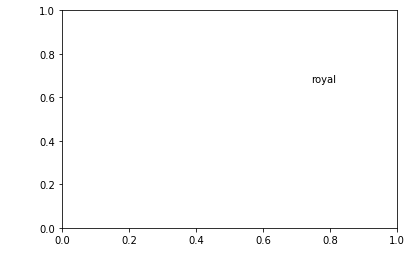

In [161]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))

plt.show()